# Welfare Maximizing Market Clearing

Given the demand function and the bids from the producers we want to clear the market such that welfare is maximized. We define welfare as the difference between market value ($V$) and producer cost ($C$).


**1. Load packages**
   - We are using the gurobipy package to formulate a mathematical model and solve it. 

In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt

**2. Define Parameters**

We study an exemplary market with 4 producers with the following offers:

| Producer       | Offer price in $/MW    | Offer amount in MW  |
|----------------|------------------------|---------------------|
| Renewable      | 0                      | 2                   |
| Cheap          | 10                     | 100                 |
| Base           | 50                     | 500                 |
| Peak           | 80                     | 20                  |

We model demand through an inverse demand-price functon: $\pi(q^D) = \beta q^D + \pi^{max}$ with the following parameters:
- $\beta= -25$
- $\pi^{max} = 11,000$.

We first define these parameters and create a basic visualization.


In [6]:
# Inverse price demand function
# pi(q) = beta * q + pi_max
beta = -25
pi_max = 11e3
# We can use a lambda function to define this relationship in a single line
pi = lambda q: beta*q + pi_max

# Generators
c = [0, 10, 50, 80] # vector of cost [$/MW]
p_max = [200, 100, 500, 200] # vector of maximum capacity [MW]
gen_type = ["RES", "cheap", "base", "peak"]
n_gen = len(c) # number of generators

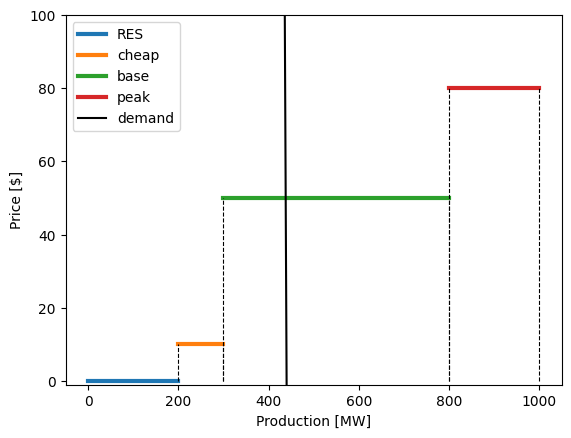

In [8]:
# Create a vizualization

# First plot the individual offer bids
fig, ax = plt.subplots(1,1)
# The subplots(x,y) command creates a figure with x rows and y columns of plots.
# Here we only want one plot. Using subplots(1,2) would create two plots next to each other inside the same figure.

# Each bid is essentially a horizontal line that we can define through its start and end point
for i in range(n_gen):
  x1 = sum(p_max[:i]) # define the start point of each line
  x2 = sum(p_max[:i+1]) # define the end point of each line
  x = [x1, x2]
  y = [c[i], c[i]]
  ax.plot(x, y, label=gen_type[i], linewidth=3) # plot the line

  # At vertical lines to make it nice
  ax.vlines([x1, x2], 0, c[i], 'black', 'dashed', linewidth=0.8)


# Now lets add the demand function by creating some points
xs = np.arange(0, 1000, 50) # creates a list of number from 0 to 1000 in steps of 50
ys = [pi(x) for x in xs] # creates a list of resulting prices using "list comprehension"

# Plot the line
ax.plot(xs, ys, 'black', label="demand")

# Enable legend
ax.legend() # turn legend on

# Add axis labels
ax.set_ylabel("Price [$]")
ax.set_xlabel("Production [MW]")

# Restrict the visible plot to the relevant area
ax.set_ylim([-1, 100]);

**3. Define mathematical model**

Let $\pi^*$ be the market price and $q^*$ the market quantity after clearing. From this we get:
\begin{align}
V &= \frac{1}{2}q^*(\pi^{max} - \pi^*) + q^*\pi^*
   = \frac{1}{2}q^*(\pi^* + \pi^{max})
   = \frac{1}{2}q^*(\beta q^* + \pi^{max} + \pi^{max}) \\
   &= \frac{1}{2} \beta (q^*)^2 + \pi^{max}q^* \\
C &= \sum_{i=1}^G c_i  q_i^{G,*}
\end{align}


So the resulting market clearing problem is:

\begin{align}
\max_{q^G, q^D} \quad &V - C \\
\text{s.t.} \quad
  & \sum_{i=1}^G c_i  q_i^{G} = q^D \\
  & q_i^G \le q_i^{G,max} \quad i \in [G] \\
  & q_i^G, q^D \ge 0
\end{align}


In [11]:
# define the optimization program

m = gp.Model()
m.setParam('OutputFlag', 0)

# variables
p = m.addVars(n_gen, lb=0, ub=GRB.INFINITY, name="p")
d = m.addVar(lb=0, ub=GRB.INFINITY, name="d")

# constraints
m.addConstr(p.sum() == d, name="enerbal")
for i in range(n_gen):
    m.addConstr(p[i] <= p_max[i])

# define objective
V = 0.5*beta*(d**2) + pi_max*d
C = sum(p[i]*c[i] for i in range(n_gen))
welfare = V - C
m.setObjective(welfare, GRB.MAXIMIZE)

In [12]:
# clear the market and print the results
m.optimize()

welfare_res = m.ObjVal
d_res = d.X
p_res = [p[i].X for i in range(n_gen)]
C_res = C.getValue()
print(f"Resulting welfare: {welfare_res:.1f} $")
print(f"Resulting generation cost: {C_res:.1f} $")
print(f"Resulting demand:  {d_res:.1f} MW")
print(f"Generator outputs:")
for i in range(n_gen):
  print(f"   {gen_type[i]}: {p_res[i]:.1f} MW")

Resulting welfare: 2412050.0 $
Resulting generation cost: 7900.0 $
Resulting demand:  438.0 MW
Generator outputs:
   RES: 200.0 MW
   cheap: 100.0 MW
   base: 138.0 MW
   peak: 0.0 MW


In [13]:
# compute the price
pi_opt = pi(d_res)
print(f"The market clearing price is {pi_opt:.1f} $/MW")

The market clearing price is 50.0 $/MW


In [14]:
# compute the dual of the energy balance

lam = m.getConstrByName("enerbal").Pi
print(f"The dual of the energy balance is {lam:.1f}")

The dual of the energy balance is -50.0


In [15]:
# let's redo the computation as our known ED with fixed demand

D = d_res

m = gp.Model()
m.setParam('OutputFlag', 0)

# variables
p = m.addVars(n_gen, lb=0, ub=GRB.INFINITY, name="p")

# constraints
m.addConstr(p.sum() == D, name="enerbal")
for i in range(n_gen):
    m.addConstr(p[i] <= p_max[i])

# define objective
C = sum(p[i]*c[i] for i in range(n_gen))
m.setObjective(C, GRB.MINIMIZE)

# clear the market and print the results
m.optimize()

welfare_res = m.ObjVal
p_res = [m.getVarByName(f"p[{i}]").X for i in range(n_gen)]
C_res = C.getValue()
print(f"Resulting welfare: {welfare_res:.1f} $")
print(f"Resulting generation cost: {C_res:.1f} $")
print(f"Resulting demand:  {d_res:.1f} MW")
print(f"Generator outputs:")
for i in range(n_gen):
  print(f"   {gen_type[i]}: {p_res[i]:.1f} MW")

print()
lam = m.getConstrByName("enerbal").Pi
print(f"The dual of the energy balance is {lam:.1f}")

Resulting welfare: 7900.0 $
Resulting generation cost: 7900.0 $
Resulting demand:  438.0 MW
Generator outputs:
   RES: 200.0 MW
   cheap: 100.0 MW
   base: 138.0 MW
   peak: 0.0 MW

The dual of the energy balance is 50.0
